In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import copy
from scipy.stats import norm
from scipy.integrate import quad

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

/Users/ronak/miniconda3/envs/mgc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Original CEF estimate function.

# def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
#     model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
#                               n_estimators = n_estimators, 
#                               max_samples= max_samples, 
#                               bootstrap = bootstrap)
#     model.fit(X, y)
#     class_counts = np.zeros((X.shape[0], model.n_classes_))
#     for idx, tree in enumerate(model): # RONAK EDIT
#         # get out of bag indicies
        
#         # RONAK EDIT STARTS HERE ################. Fully out of bag samples.
        
#         #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
#         sampled_indices = model.estimators_samples_[idx]
#         unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
#         # RONAK EDIT ENDS HERE ##################.
        
#         total_unsampled = len(unsampled_indices)
#         np.random.shuffle(unsampled_indices)
#         prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
#         # get all node counts
#         node_counts = tree.tree_.n_node_samples
#         # get probs for eval samples
#         posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
#         for prob_index in prob_indices:
#             posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
#         row_sums = posterior_class_counts.sum(axis=1)
#         row_sums[row_sums == 0] = 1
#         class_probs = (posterior_class_counts/row_sums[:, None])
        
#         where_0 = np.argwhere(class_probs == 0)
#         for elem in where_0:
#             class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
#         where_1 = np.argwhere(class_probs == 1)
#         for elem in where_1:
#             class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
#         class_probs.tolist()
#         partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
#         # get probability for out of bag samples
#         eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
#         eval_class_probs = np.array(eval_class_probs)
#         # find total elements for out of bag samples
#         elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
#         # store counts for each x (repeat fhis for each tree)
#         class_counts[eval_indices] += elems
#     # calculate p(y|X = x) for all x's
#     probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
#     entropies = -np.sum(np.log(probs)*probs, axis = 1)
#     # convert nan to 0
#     entropies = np.nan_to_num(entropies)
#     return np.mean(entropies)

# np.warnings.filterwarnings('ignore')

In [3]:
# The following has a bunch of returns to analyze.

def cef_estimate(X, y, X_mc, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    posteriors = [] #
    estimation_node_counts = [] #
    mc_posterior = np.zeros((X_mc.shape[0], model.n_classes_))
    
    for idx, tree in enumerate(model): # RONAK EDIT
        # get out of bag indicies
        
        # EDIT STARTS HERE ################. Fully out of bag samples.
        
        # unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = model.estimators_samples_[idx]
        unsampled_indices = np.delete(np.arange(0, len(X)), sampled_indices)
        
        # EDIT ENDS HERE ##################.
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
    
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        estimation_node_counts.append(copy.deepcopy(row_sums))
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        posteriors.append(class_probs) #
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
        
        #### Do the same for MC indices.
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X_mc)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X_mc)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        mc_posterior += elems
        ####
        
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    
    avg_mc_posterior = mc_posterior / mc_posterior.sum(axis = 1, keepdims = True)
    return np.mean(entropies), posteriors, model, estimation_node_counts, avg_mc_posterior

np.warnings.filterwarnings('ignore')

In [4]:
def generate_data(n, d = 2, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(0, n_1), np.repeat(1, n - n_1)))
  
    return X, y

def plot_data(X, y, lim = 4):
    sns.set()
    
    palette = sns.color_palette("Dark2")
    colors = [palette[0], palette[2]]
        
    # Data.
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    ax.scatter(X[:, 0], X[:, 1], s=180, marker='.', c=np.array(colors)[y], edgecolors = 'k')
    ax.set_ylim(-lim, lim)
    ax.set_xlim(-lim, lim)
    ax.set_aspect('equal')

    ax.set_yticks([])
    ax.set_xticks([])

    plt.tight_layout()
    plt.show()

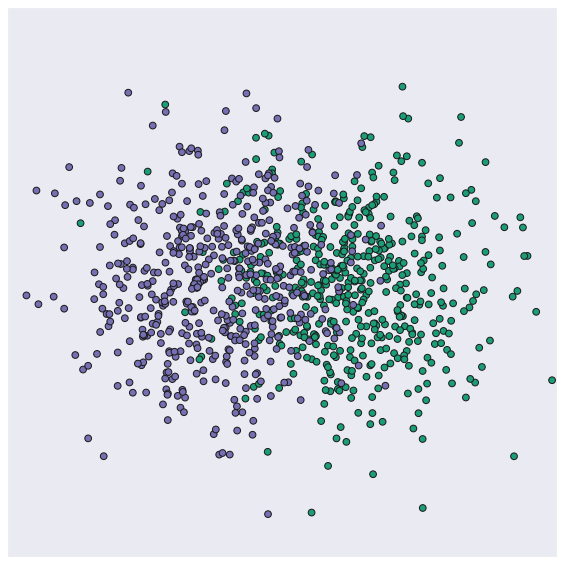

In [5]:
n = 1000
d = 2
X, y = generate_data(n)

plot_data(X, y)

In [6]:
def true_posterior(x1, mu):
    return norm.pdf(x1, mu, 1) / (norm.pdf(x1, mu, 1) + norm.pdf(x1, -mu, 1))

def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

In [34]:
def metrics(n, d, mu, num_trials, num_mc, n_estimators = 50):
    X_mc, y_mc = generate_data(num_mc, d = d, mu = mu)
    
    def worker(trial):
        X, y = generate_data(n, d = d, mu = mu)
        
        # Estimate conditional entropy.
        cond_entropy, posteriors, model, estimation_node_counts, avg_mc_posterior = cef_estimate(X, y, X_mc, n_estimators = n_estimators, depth = 30)
        
        # Probability of empty leaf.
        counts = np.zeros(n)
        for t, tree in enumerate(model):
            # Figure out which leaves the MC samples fall into, and count the estimation points in each.
            mc_node_counts = [estimation_node_counts[t][x] for x in tree.apply(X_mc)]
            for i in mc_node_counts: 
                counts[int(i)] += 1
        
        return counts
    
    def worker2(trial):
        X, y = generate_data(n, d = d, mu = mu)
        
        # Estimate conditional entropy.
        cond_entropy, posteriors, model, estimation_node_counts, avg_mc_posterior = cef_estimate(X, y, X_mc, n_estimators = n_estimators, depth = 30)
        
        err = 0.0
        abs_err = 0.0
        for i, x in enumerate(X_mc):
            diff = avg_mc_posterior[i, 0] - true_posterior(x[0], mu = mu)
            err += diff
            abs_err += np.absolute(diff)
        err /= num_mc
        abs_err /= num_mc
        
        return err, abs_err, cond_entropy
            
    counts_by_n = np.mean(np.array(Parallel(n_jobs=-2)(delayed(worker)(trial) for trial in range(num_trials))), axis = 0)
    counts_by_n /= (n_estimators * num_mc)
    
    # Find last nonzero.
    end = n
    for i in range(n-1, 0, -1):
        if counts_by_n[i] != 0:
            end = i+1
            break
            
    neighbor_dist = counts_by_n[0:end]
    prob_empty = neighbor_dist[0]
    
    # Average distance from true posterior.
    errs = np.array(Parallel(n_jobs=-2)(delayed(worker2)(trial) for trial in range(num_trials)))
    avg_err = np.mean(errs[:, 0])
    avg_abs_err = np.mean(errs[:, 1])
    avg_cond_entropy = np.mean(errs[:, 2])
    
    return prob_empty, neighbor_dist, avg_err, avg_abs_err, avg_cond_entropy

In [35]:
n = 1000
d = 40
mu = 1
num_trials = 20
num_mc = 4000

prob_empty, neighbor_dist, avg_err, avg_abs_err, cond_entropy = metrics(n, d, mu, num_trials, num_mc, n_estimators = 50)

In [36]:
print("Setting: \t\t n = %d, d = %d, mu = %0.1f" % (n, d, mu))
print("Prob. empty leaf:\t", prob_empty)
print("Avg. error:\t\t", avg_err)
print("Avg. absolute error:\t", avg_abs_err)
print("Estimated cond. entropy:", cond_entropy)
print("True cond. entropy:\t", true_cond_entropy(mu))

Setting: 		 n = 1000, d = 40, mu = 1.0
Prob. empty leaf:	 0.02100475
Avg. error:		 0.004821328625055488
Avg. absolute error:	 0.09699452001797329
Estimated cond. entropy: 0.5212772630977933
True cond. entropy:	 0.3563163602131145


<BarContainer object of 150 artists>

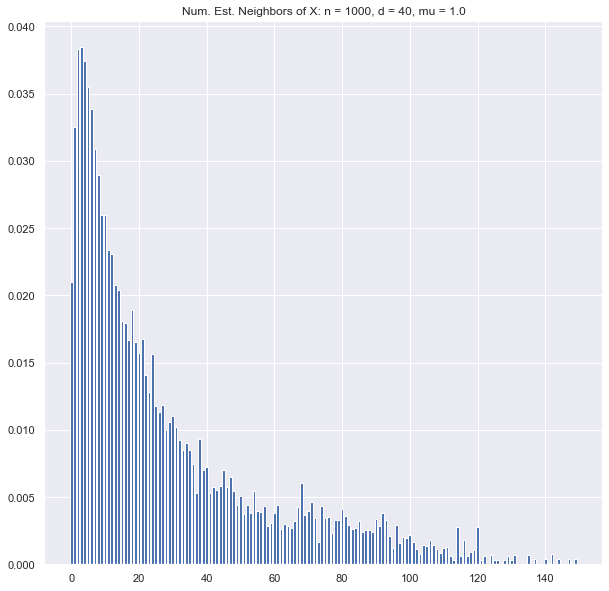

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

N = len(neighbor_dist)
ax.set_title("Num. Est. Neighbors of X: n = %d, d = %d, mu = %0.1f" % (n, d, mu))
ax.bar(np.arange(N), neighbor_dist)